In [841]:
#Import necessary libs
import os
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns #For heatmap
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn import preprocessing

import catboost as cb
%matplotlib inline

pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)

In [842]:
def to_hourly(df):
    df['date_forecast']
    df.set_index('date_forecast', inplace=True)
    df = df.resample('H').mean()
    df.reset_index(inplace=True)
    return df

# ToDo 

- Normalize features. How do we handle the nans??

### Loading all data given and resampling to hourly measurements by mean

In [843]:
# Train target for each location:
train_a = pd.read_parquet('data/A/train_targets.parquet')
train_b = pd.read_parquet('data/B/train_targets.parquet')
train_c = pd.read_parquet('data/C/train_targets.parquet')


# Estimated training data for each location
X_train_estimated_a = to_hourly(pd.read_parquet('data/A/X_train_estimated.parquet'))
X_train_estimated_b = to_hourly(pd.read_parquet('data/B/X_train_estimated.parquet'))
X_train_estimated_c = to_hourly(pd.read_parquet('data/C/X_train_estimated.parquet'))



# Observed training data for each location
X_train_observed_a = to_hourly(pd.read_parquet('data/A/X_train_observed.parquet'))
X_train_observed_b = to_hourly(pd.read_parquet('data/B/X_train_observed.parquet'))
X_train_observed_c = to_hourly(pd.read_parquet('data/C/X_train_observed.parquet'))



# Estimated test data for each location
X_test_estimated_a = to_hourly(pd.read_parquet('data/A/X_test_estimated.parquet'))
X_test_estimated_b = to_hourly(pd.read_parquet('data/B/X_test_estimated.parquet'))
X_test_estimated_c = to_hourly(pd.read_parquet('data/C/X_test_estimated.parquet'))

#Remove nan rows 
X_test_estimated_a = X_test_estimated_a.dropna(subset = ['date_calc'] ,how = 'all')
X_test_estimated_b = X_test_estimated_b.dropna(subset = ['date_calc'] ,how = 'all')
X_test_estimated_c = X_test_estimated_c.dropna(subset = ['date_calc'] ,how = 'all')



In [844]:
subset_select = True #Select subset of features based on list below
location = True #add categorical location feature
type = False #add categorical type feature (estimated or observed)


selected_features_obs = [
    'time',
    'clear_sky_energy_1h:J',
    'effective_cloud_cover:p',
]
# selected_features_est = [
#     'time',
#     'type',
#     'location',
#     'clear_sky_energy_1h:J',
#     'effective_cloud_cover:p',
#     'is_day:idx', # Need to make categorical if it is included
#     't_1000hPa:K'
# ]

### Helper functions to tidy up and prepare for fit

In [845]:
def add_type(data, type):
    data['type'] = [type] * len(data)
    data['type'] = data['type'].astype('category')

def combine_obs_est(est, obs, lable = False):
    """
    Concatinates the estimated and observed data. 
    Adds a categorical variable "type": "obs" for observed and "est" for estimated if lable = True.
    Removes data_calc from est.
    """
    if lable:
        add_type(est, 'est')
        add_type(obs, 'obs')
    
    est = est.drop('date_calc', axis = 1)
    X_train = pd.concat([est, obs])
    X_train = X_train.reset_index(drop=True)
    
    return X_train

def add_location(data, location):
    """
    Adds a categorical feature "location" equal to the input string location.
    """
    loc = [location] * len(data)
    data['location'] = loc
    data['location'] = data['location'].astype('category')


def match_X_Y(X,Y):
    """ 
    date_forecast and time must be unique!
    Matches the timestamps of X to the timestamps of Y. 
    Makes sure that the length of X and Y are equal.
    """
    Y = Y.dropna()
    X = X.rename(columns={'date_forecast': 'time'})
    merge_df = Y.merge(X, on="time", how='inner')
    Y = merge_df['pv_measurement']
    X = merge_df.drop(columns = ['pv_measurement'])
    return X,Y


In [846]:



X_train_a = combine_obs_est(X_train_estimated_a, X_train_observed_a, type)
X_train_b = combine_obs_est(X_train_estimated_b, X_train_observed_b, type)
X_train_c = combine_obs_est(X_train_estimated_c, X_train_observed_c, type)


if location:
    add_location(X_train_a, 'a')
    add_location(X_train_b, 'b')
    add_location(X_train_c, 'c')

X_a, Y_a = match_X_Y(X_train_a, train_a)
X_b, Y_b = match_X_Y(X_train_b, train_b)
X_c, Y_c = match_X_Y(X_train_c, train_c)

Y_train = pd.concat([Y_a, Y_b, Y_c])
Y_train = Y_train.reset_index(drop=True)

X_train = pd.concat([X_a, X_b,X_c])
X_train = X_train.rename(columns={'date_forecast': 'time'})
if subset_select:
    X_train = X_train[selected_features_obs]
X_train = X_train.sort_values(by='time')
X_train = X_train.reset_index(drop=True)
X_train = X_train.drop('time', axis=1)


In [847]:
#Test X data
if location:
    add_location(X_test_estimated_a, 'a')
    add_location(X_test_estimated_b, 'b')
    add_location(X_test_estimated_c, 'c')
if type:
    add_type(X_test_estimated_a, 'est')
    add_type(X_test_estimated_b, 'est')
    add_type(X_test_estimated_c, 'est')



X_test = pd.concat([X_test_estimated_a, X_test_estimated_b,X_test_estimated_c])

X_test = X_test.rename(columns={'date_forecast': 'time'})
if subset_select:
    X_test = X_test[selected_features_obs]
X_test = X_test.sort_values(by='time')
X_test = X_test.drop('time', axis=1)



In [848]:
# normalize = True
# if normalize:
#     d = preprocessing.normalize(X_train, axis=0)
#     X_train = pd.DataFrame(d, columns=X_train.columns)
#     d = preprocessing.normalize(X_test, axis=0)
#     X_test = pd.DataFrame(d, columns=X_test.columns)
    

### Final steps

In [849]:
# train_pool = cb.Pool(
#     X_train,
#     Y_train,
#     cat_features = ['location']
# )
# test_pool = cb.Pool(
#     X_test,
#     cat_features = ['location']
# )
train_pool = cb.Pool(
    X_train,
    Y_train
)
test_pool = cb.Pool(
    X_test
)

model = cb.CatBoostRegressor(
    iterations = 100,
    depth =2,
    learning_rate =1,
    loss_function ='RMSE',
)


In [850]:
#train the model
model.fit(train_pool)
# make the prediction using the resulting model
preds = model.predict(test_pool)
# print(preds)

0:	learn: 764.5734933	total: 32.1ms	remaining: 3.18s
1:	learn: 763.7414799	total: 42.2ms	remaining: 2.07s
2:	learn: 763.5796150	total: 46.7ms	remaining: 1.51s
3:	learn: 763.3544056	total: 50.2ms	remaining: 1.21s
4:	learn: 763.2258935	total: 54ms	remaining: 1.03s
5:	learn: 762.9986707	total: 60.4ms	remaining: 947ms
6:	learn: 762.9024186	total: 65ms	remaining: 864ms
7:	learn: 762.7574538	total: 68.3ms	remaining: 785ms
8:	learn: 762.6787723	total: 74.5ms	remaining: 754ms
9:	learn: 762.6412102	total: 80ms	remaining: 720ms
10:	learn: 762.6245320	total: 83.5ms	remaining: 676ms
11:	learn: 762.5893098	total: 88.4ms	remaining: 648ms
12:	learn: 762.5624051	total: 94.8ms	remaining: 634ms
13:	learn: 762.4607764	total: 99.8ms	remaining: 613ms
14:	learn: 762.4052142	total: 105ms	remaining: 595ms
15:	learn: 762.3378905	total: 111ms	remaining: 585ms
16:	learn: 762.2371664	total: 115ms	remaining: 562ms
17:	learn: 762.1626091	total: 120ms	remaining: 547ms
18:	learn: 762.1193335	total: 124ms	remaining: 5

42:	learn: 761.0649447	total: 229ms	remaining: 304ms
43:	learn: 761.0491647	total: 234ms	remaining: 298ms
44:	learn: 761.0155306	total: 239ms	remaining: 292ms
45:	learn: 760.9850471	total: 243ms	remaining: 285ms
46:	learn: 760.9466352	total: 248ms	remaining: 279ms
47:	learn: 760.8835708	total: 253ms	remaining: 274ms
48:	learn: 760.8446818	total: 257ms	remaining: 267ms
49:	learn: 760.8255044	total: 262ms	remaining: 262ms
50:	learn: 760.7984306	total: 266ms	remaining: 256ms
51:	learn: 760.7379426	total: 270ms	remaining: 249ms
52:	learn: 760.7159644	total: 273ms	remaining: 242ms
53:	learn: 760.6733596	total: 277ms	remaining: 236ms
54:	learn: 760.6453112	total: 281ms	remaining: 230ms
55:	learn: 760.6009835	total: 285ms	remaining: 224ms
56:	learn: 760.5594762	total: 288ms	remaining: 217ms
57:	learn: 760.5237057	total: 292ms	remaining: 211ms
58:	learn: 760.4939179	total: 296ms	remaining: 206ms
59:	learn: 760.4629625	total: 299ms	remaining: 199ms
60:	learn: 760.4391214	total: 303ms	remaining:

In [851]:
X_test.shape

(2160, 2)

In [852]:
# preds.shape, y_test["pv_measurement"].shape

# mean_absolute_error(preds, y_test)

preds.shape
preds

array([287.20939056, 287.20939056, 211.6961093 , ..., 208.64330796,
       208.64330796, 208.64330796])

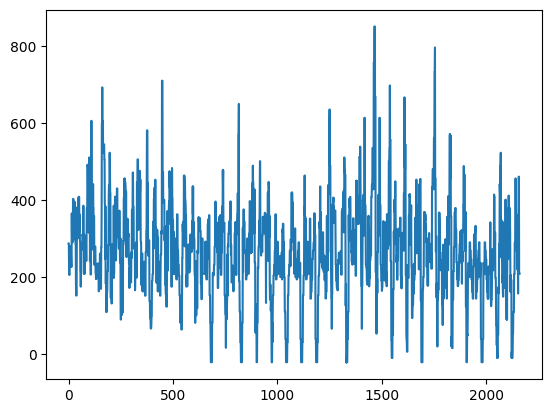

In [853]:
plt.plot(preds)
# plt.plot(Y_train)

In [854]:
def pred_to_delivery(preds, filename):
    data = {'prediction':preds}
    sub = pd.DataFrame(data = data)
    sub = sub.reset_index()
    sub = sub.rename(columns={'index': 'id'})
    sub.to_csv(filename, index=False)

In [855]:
# pred_to_delivery(preds, 'naive_catboost_3.csv')